# Week 1: Introduction to Convolutional Neural Networks

## Introduction to Computer Vision

`Computer vision` has rapidly evolved into one of the most transformative applications of deep learning. In this tutorial, I'll guide you through the foundational concepts of `Convolutional Neural Networks` (`CNNs`) as taught by Andrew Ng in Week 1 of the CNN course.

- [Reference](https://www.youtube.com/watch?v=ArPaAX_PhIs&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF&index=2&ab_channel=DeepLearningAI)


## The Challenge of Computer Vision

- Traditional machine learning methods struggle with images because of the high dimensionality of the data. Consider a modest $64×64$ pixel color image - this translates to $64×64×3 = 12,288$ input features.

- Scaling to larger, more practical image sizes like $1000×1000$ pixels would require millions of parameters, making traditional neural networks computationally expensive and prone to overfitting.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)

## Edge Detection: The Building Block

One of the first steps in understanding an image is **detecting `edges`** - the boundaries between different objects or regions. CNNs build upon this fundamental concept.

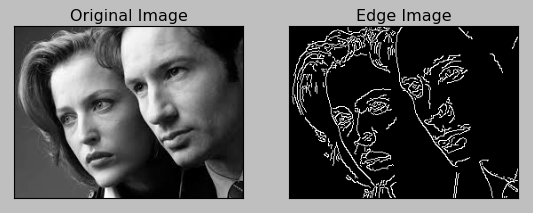

### What is an Edge?

- An edge is where **pixel values change significantly**, often indicating the boundary of an object.

- Edge detection works by applying `filters` (or `kernels`) to detect vertical, horizontal, or diagonal edges.


### Vertical Edge Detection

- To detect vertical edges, we can apply a filter such as:

  ```
  [1, 0, -1]
  [1, 0, -1]
  [1, 0, -1]
  ```

  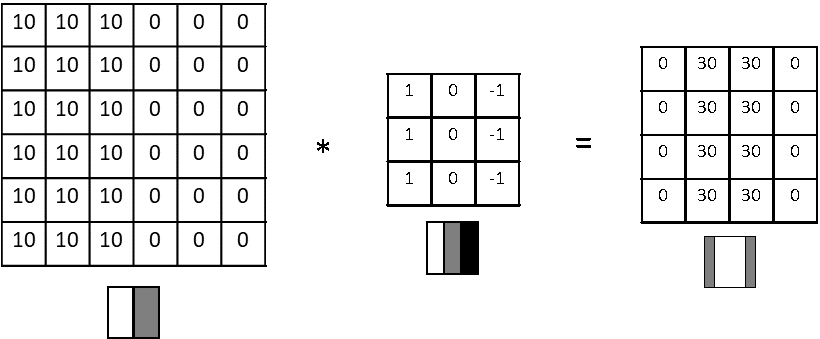

- For horizontal edges, we might use:

  ```
  [ 1,  1,  1]
  [ 0,  0,  0]
  [-1, -1, -1]
  ```

  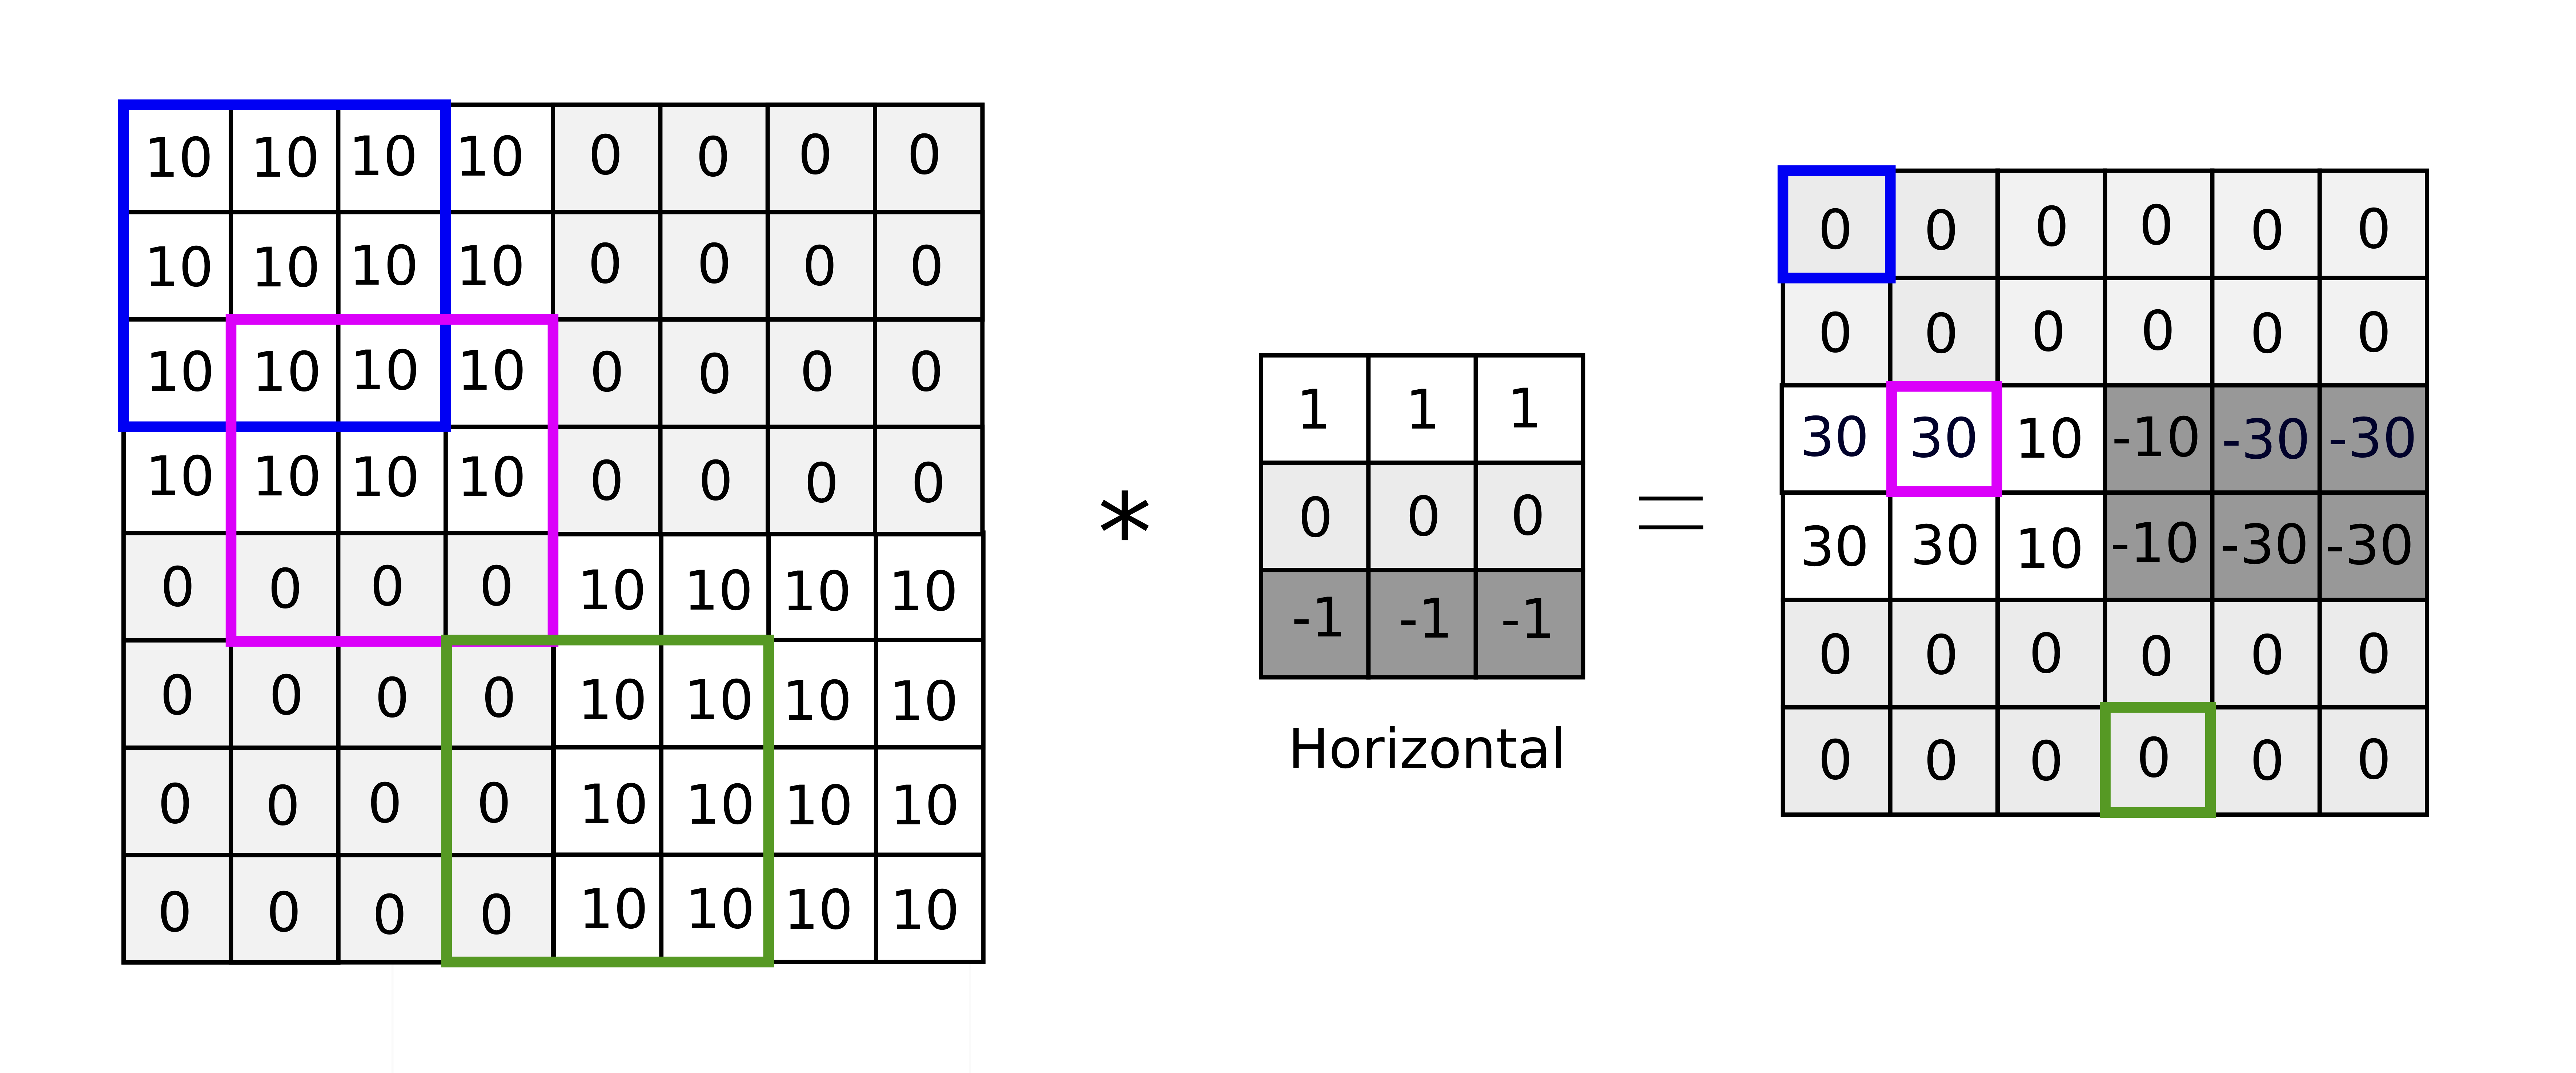

- You can change the weight for different purpose, for example, here's material for [Sobel filter](https://www.projectrhea.org/rhea/index.php/An_Implementation_of_Sobel_Edge_Detection), which us

  ```
  [ 1,  2,  1]
  [ 0,  0,  0]
  [-1, -2, -1]
  ```

- Also, you can change the weight to detect any angle of boundary, we will talk about how to use back propagation to find these weights in next chapter.


### The Mechanics of Convolution

Consider a 6×6 image and a 3×3 filter:

1. Place the filter on the top-left corner of the image
2. Perform element-wise multiplication and sum the results
3. Place this sum in the corresponding position of the output matrix
4. Slide the filter to the right and repeat steps 2-3
5. Continue until the entire image is processed

The resulting output is called a `feature map` or `activation map` and will be of size $4×4$ for a $6×6$ image with a $3×3$ `filter` (without `padding`).


## Code - Part 1: Manual Convolution Implementation

The first section (`visualize_convolution()`) shows how convolution works at its most fundamental level. Here's what it demonstrates:

1. Creating a simple $8×8$ image with a square in two corners

2. Applying vertical and horizontal edge detection filters manually

3. Showing how these filters extract different features from the same image

This manual implementation helps you understand the mathematics behind convolution - how the filter slides over the image, performs element-wise multiplication, and produces a feature map.


Demonstrating basic convolution operations with a shared legend...


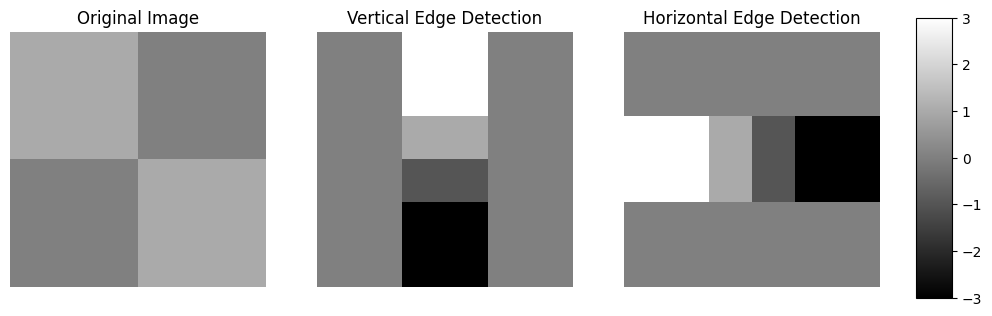

In [2]:
def visualize_convolution():
    # Create a simple 8x8 image (single channel)
    image = torch.zeros(8, 8)
    image[0:4, 0:4] = 1.0  # top-left square of ones
    image[4:8, 4:8] = 1.0  # bottom-right square of ones
    
    # Create the vertical edge detection filter
    vertical_filter = torch.tensor([
        [1, 0, -1],
        [1, 0, -1],
        [1, 0, -1]
    ], dtype=torch.float32)
    
    # Create the horizontal edge detection filter
    horizontal_filter = torch.tensor([
        [ 1,  1,  1],
        [ 0,  0,  0],
        [-1, -1, -1]
    ], dtype=torch.float32)
    
    # Perform manual convolution for vertical and horizontal edge detection
    vertical_output = torch.zeros(6, 6)
    horizontal_output = torch.zeros(6, 6)
    for i in range(6):
        for j in range(6):
            patch = image[i:i+3, j:j+3]
            vertical_output[i, j] = torch.sum(patch * vertical_filter)
            horizontal_output[i, j] = torch.sum(patch * horizontal_filter)
    
    # Determine a common value range for the color scale
    all_data = torch.cat([image.flatten(), vertical_output.flatten(), horizontal_output.flatten()])
    vmin = all_data.min().item()
    vmax = all_data.max().item()
    
    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    im0 = axes[0].imshow(image.numpy(), cmap='gray', vmin=vmin, vmax=vmax)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    im1 = axes[1].imshow(vertical_output.numpy(), cmap='gray', vmin=vmin, vmax=vmax)
    axes[1].set_title('Vertical Edge Detection')
    axes[1].axis('off')
    
    im2 = axes[2].imshow(horizontal_output.numpy(), cmap='gray', vmin=vmin, vmax=vmax)
    axes[2].set_title('Horizontal Edge Detection')
    axes[2].axis('off')
    
    # Adjust layout to make room for the colorbar
    plt.subplots_adjust(right=0.85)
    # Create a new axis for the colorbar on the right side
    cbar_ax = fig.add_axes([0.88, 0.15, 0.03, 0.7])
    fig.colorbar(im0, cax=cbar_ax)
    
    plt.show()

print("Demonstrating basic convolution operations with a shared legend...")
visualize_convolution()


## Padding

When applying convolution, the output size shrinks (an $n×n$ image with an $f×f$ filter produces an $(n-f+1)×(n-f+1)$ output). This has two disadvantages:

1. Information at the edges is used less frequently

2. The size reduction limits the number of layers we can stack

To address these issues, we use `padding` - adding a **border of pixels** (usually zeros) around the image.

### "Valid" vs "Same" Padding

- `Valid padding`: No padding (output size: $n-f+1 × n-f+1$)

- `Same padding`: Add enough padding so that output size equals input size

  - For a filter of size $f×f$, we add $(f-1)/2$ pixels on all sides (when $f$ is odd)

  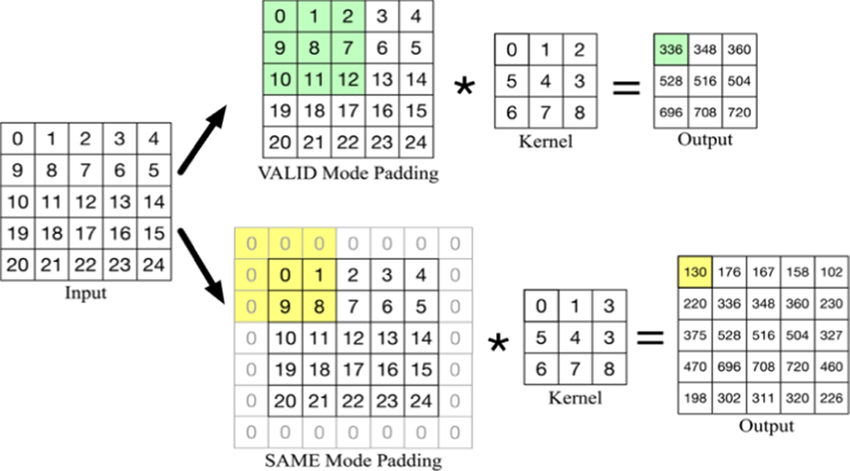


## Stride

`Stride` controls how the filter moves across the image. With a stride of $2$, the filter jumps $2$ pixels at a time, reducing the output size.

- For an $n×n$ image, $f×f$ filter, padding $p$, and stride $s$, the output size is:

  $$
  ⌊(n+2p-f)/s + 1⌋ × ⌊(n+2p-f)/s + 1⌋
  $$

- Where $⌊ ⌋$ represents the floor function.

  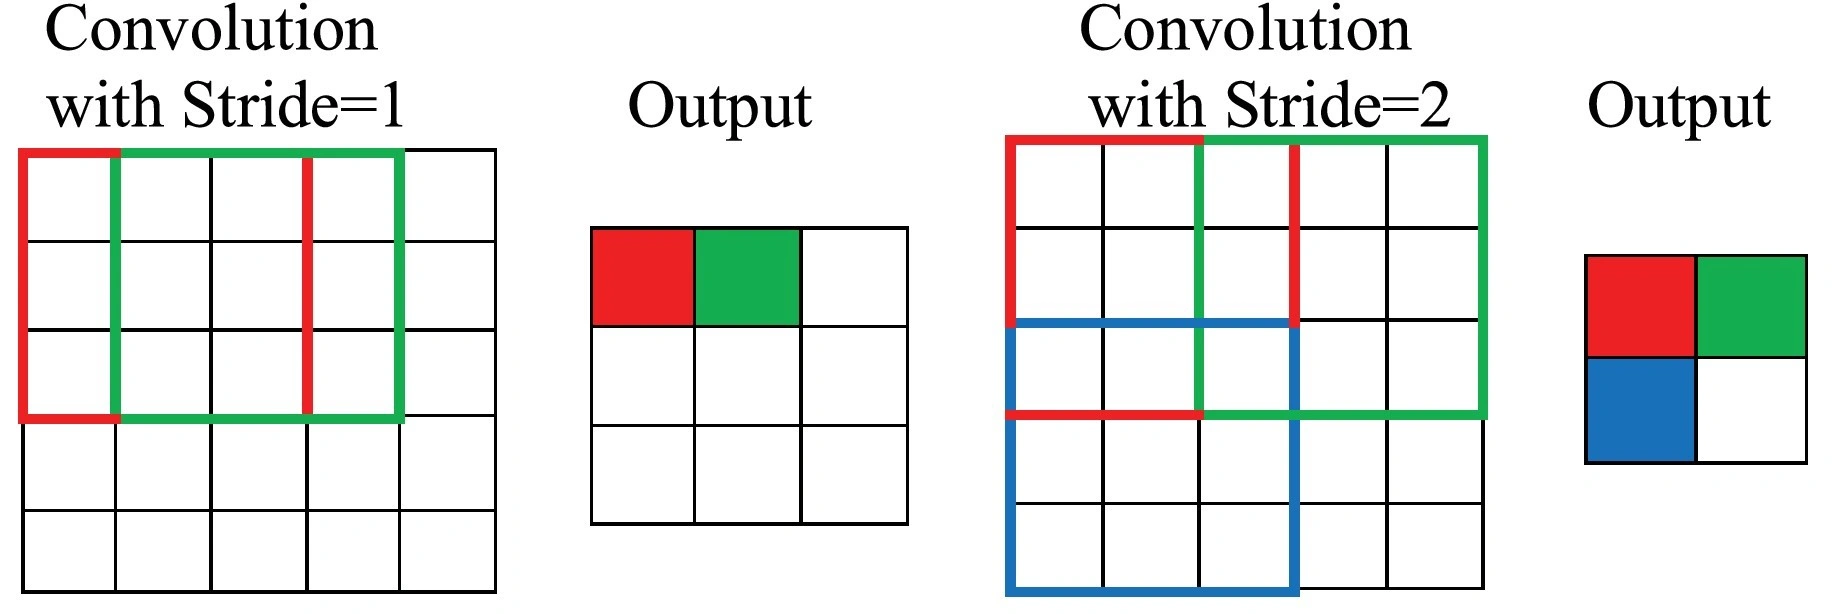


## Convolutions Over Volume

- Real-world images have multiple channels (`RGB`). To handle this, we use `3D filters`.

- For example, if we have a $6×6×3$ image ($height × width × channels$) and a $3×3×3$ filter, the output will be a $4×4×1$ feature map.

  - Each position involves $27$ multiplications ($3×3×3$) and one addition.

  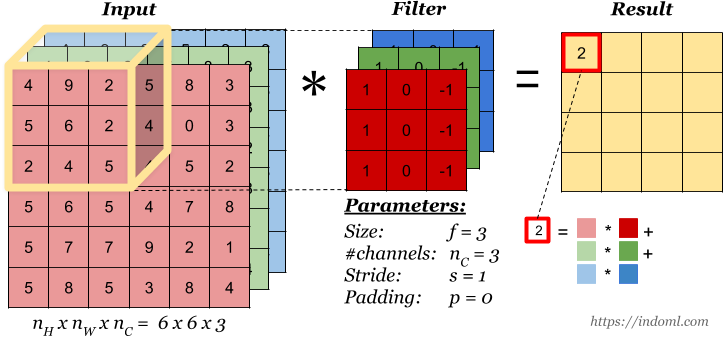

### Multiple Filters

- In practice, we use multiple filters to detect different features (edges, curves, textures). With n filters, our output becomes an n-channel feature map.

- For example, using $2$ filters on a $6×6×3$ image produces a $4×4×2$ output.

  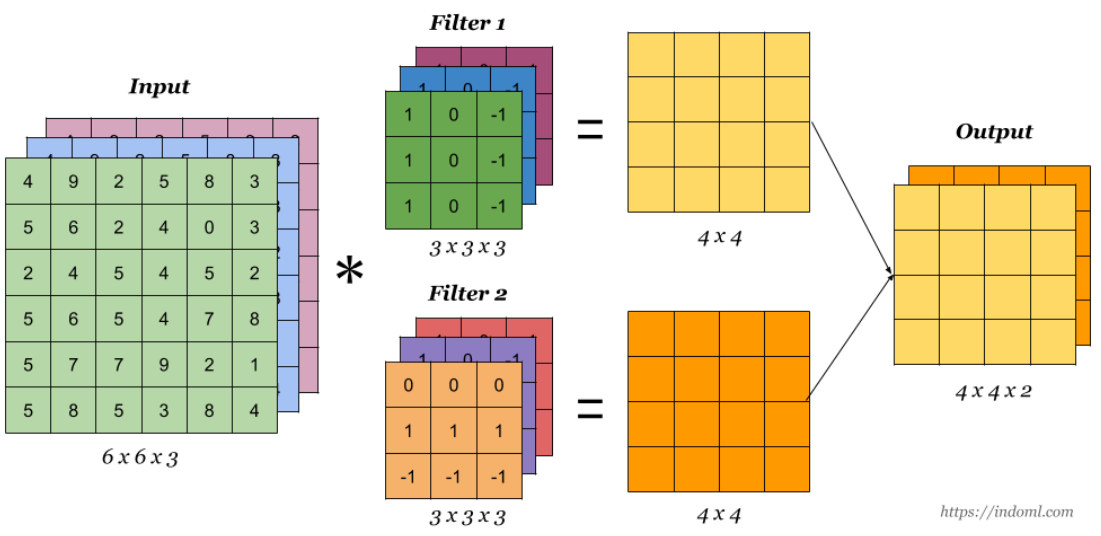


## The Building Blocks of CNNs

A typical CNN consists of:

1. **Convolutional layers**: Apply `filters` to detect features

2. **Activation functions**: Introduce non-linearity (typically `ReLU`)

3. **Pooling layers**: Downsample the feature maps

4. **Fully connected layers**: Perform classification based on extracted features

   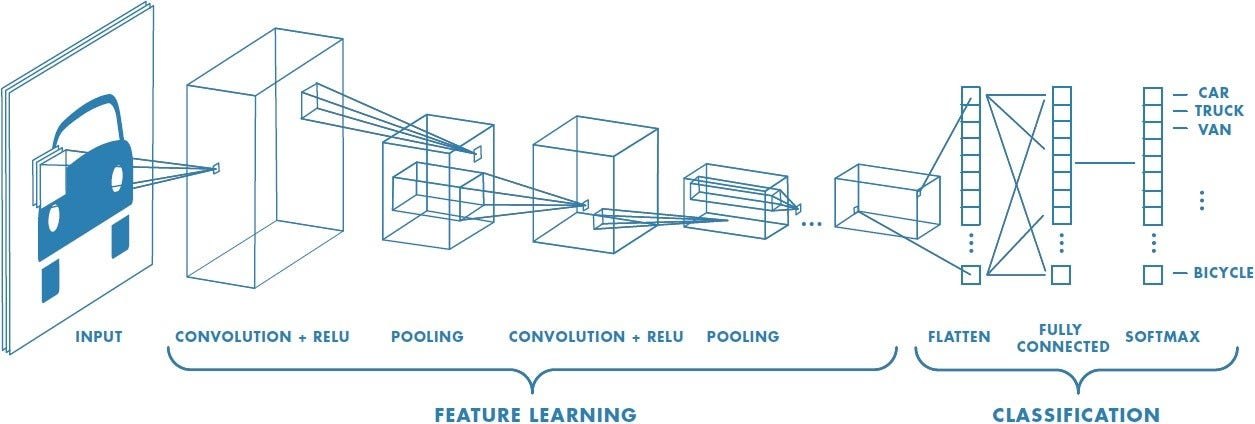


## Code - Part 2: PyTorch's Built-in Convolution Layers

In `pytorch_convolutions()`, we use PyTorch's `nn.Conv2d` to implement different types of convolutions:

1. **Valid convolution (no padding)**: The output is smaller than the input

2. **Same convolution (with padding)**: The output has the same spatial dimensions as the input

3. **Strided convolution**: The filter skips pixels, reducing the output size further

This section bridges the conceptual understanding with practical `PyTorch` implementation, showing how parameters like padding and stride affect the output dimensions.



Demonstrating PyTorch convolutions with a shared legend...


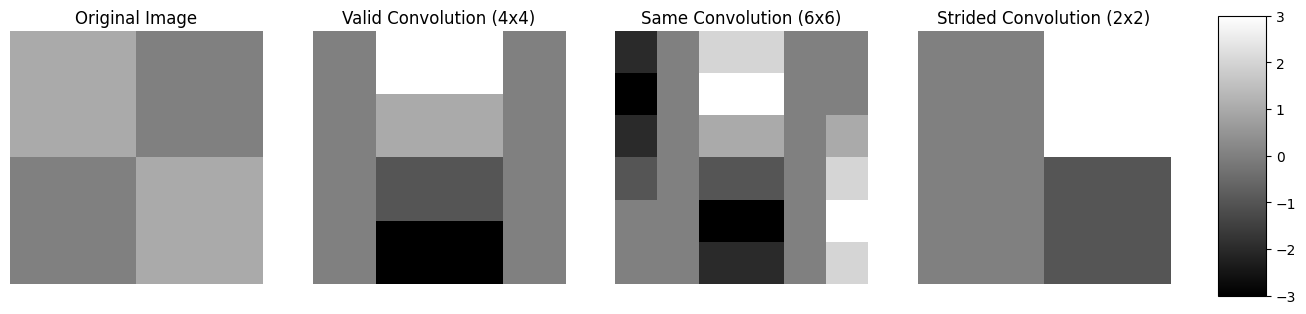

In [3]:
def pytorch_convolutions():
    # Create a sample image tensor: 1 is batch size, 1 is channel, 6x6 is size
    image = torch.zeros(1, 1, 6, 6)
    image[0, 0, 0:3, 0:3] = 1.0  # Create a small square in the top-left corner
    image[0, 0, 3:6, 3:6] = 1.0  # Create a small square in the bottom-right corner
    
    # Define filters as PyTorch conv2d layers
    conv_valid = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=0, bias=False)
    conv_same = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1, bias=False)
    conv_strided = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=2, padding=0, bias=False)
    
    # Set the weights to be our vertical edge detection filter
    vertical_filter = torch.tensor([[[[1, 0, -1],
                                       [1, 0, -1],
                                       [1, 0, -1]]]], dtype=torch.float32)
    
    conv_valid.weight = nn.Parameter(vertical_filter)
    conv_same.weight = nn.Parameter(vertical_filter)
    conv_strided.weight = nn.Parameter(vertical_filter)
    
    # Apply convolutions
    output_valid = conv_valid(image)
    output_same = conv_same(image)
    output_strided = conv_strided(image)
    
    # Extract numpy arrays from the tensors for visualization
    original = image[0, 0].detach().numpy()
    valid = output_valid[0, 0].detach().numpy()
    same = output_same[0, 0].detach().numpy()
    strided = output_strided[0, 0].detach().numpy()
    
    # Compute a common color scale range (vmin, vmax) across all images
    all_data = np.concatenate([original.flatten(), valid.flatten(), same.flatten(), strided.flatten()])
    vmin = all_data.min()
    vmax = all_data.max()
    
    # Create subplots for each image with a shared colormap range
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    
    im0 = axes[0].imshow(original, cmap='gray', vmin=vmin, vmax=vmax)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    im1 = axes[1].imshow(valid, cmap='gray', vmin=vmin, vmax=vmax)
    axes[1].set_title('Valid Convolution (4x4)')
    axes[1].axis('off')
    
    im2 = axes[2].imshow(same, cmap='gray', vmin=vmin, vmax=vmax)
    axes[2].set_title('Same Convolution (6x6)')
    axes[2].axis('off')
    
    im3 = axes[3].imshow(strided, cmap='gray', vmin=vmin, vmax=vmax)
    axes[3].set_title('Strided Convolution (2x2)')
    axes[3].axis('off')
    
    # Adjust layout to make room for the colorbar on the right side
    plt.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.88, 0.15, 0.03, 0.7])
    fig.colorbar(im0, cax=cbar_ax)
    
    plt.show()

print("\nDemonstrating PyTorch convolutions with a shared legend...")
pytorch_convolutions()

## Pooling Layers
Pooling reduces the spatial dimensions of feature maps, making the network more computationally efficient and helping it focus on important features.

### Max Pooling
- `Max pooling` takes the maximum value in each window. For example, with a $2×2$ filter and stride $2$, each $2×2$ block is reduced to a single maximum value.

- `Max pooling` helps make feature detection more robust to small translations in the input.

    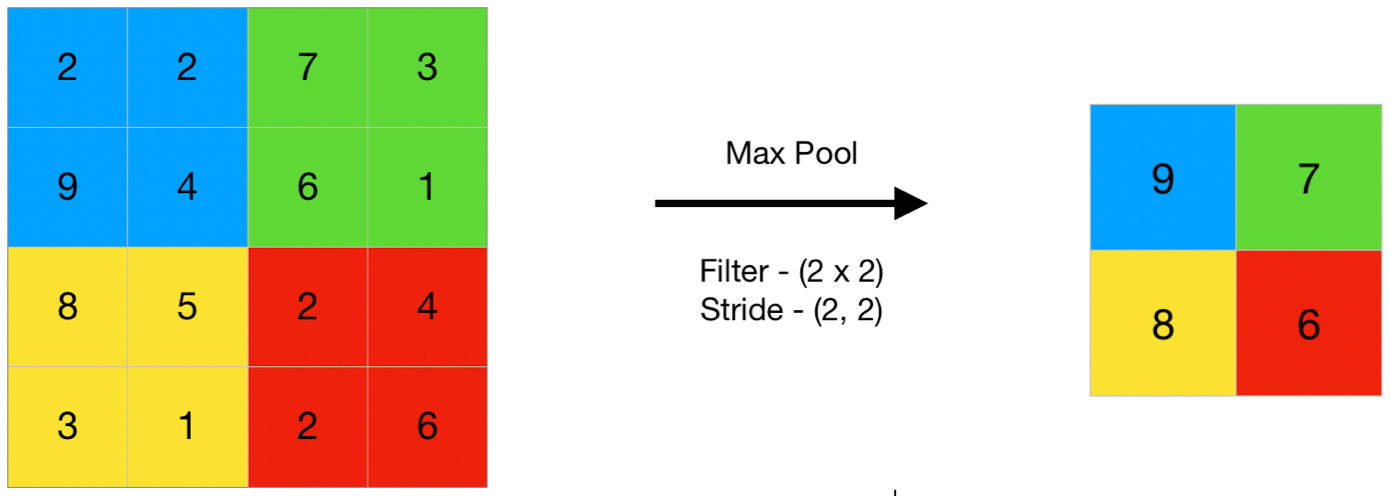

### Average Pooling
- `Average pooling` takes the average of values in each window. It's less common but sometimes used in the final layers of the network.

- Pooling layers have no parameters to learn - they simply apply a fixed operation.

    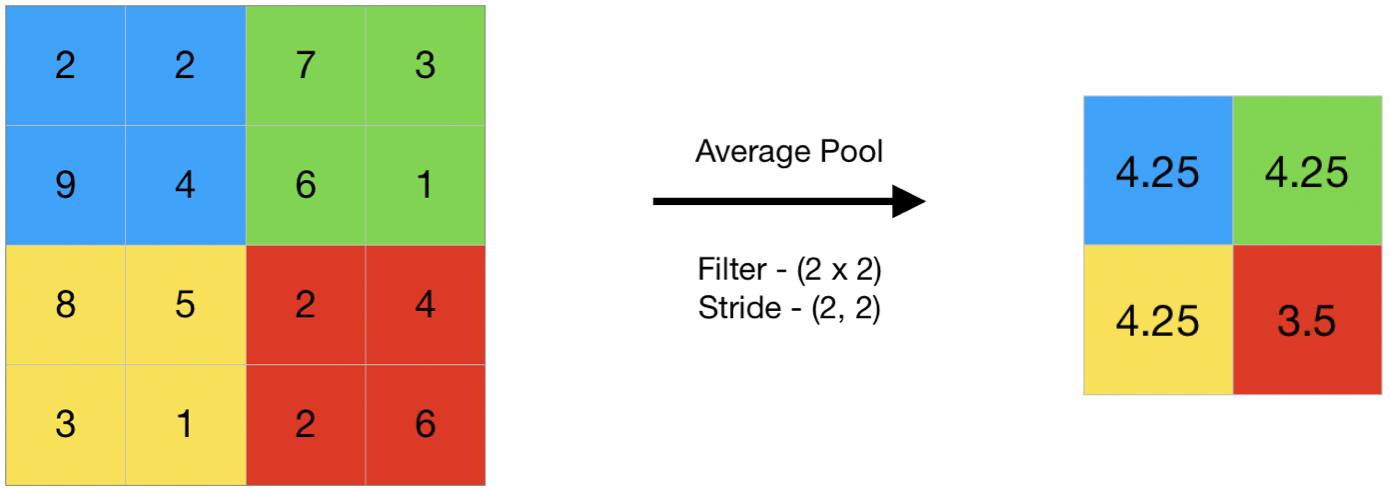

## Code - Part 3: Pooling Operations
The `pooling_operations()` function visualizes how max pooling and average pooling work:

- We create a $4×4$ feature map with sequential values

- Apply `max pooling` and `average pooling` with $2×2$ filters
  
- Visualize the results to see how information is compressed

This demonstrates why max pooling is particularly good at preserving important features while reducing spatial dimensions - it keeps the strongest activations.


Demonstrating pooling operations with a shared legend...


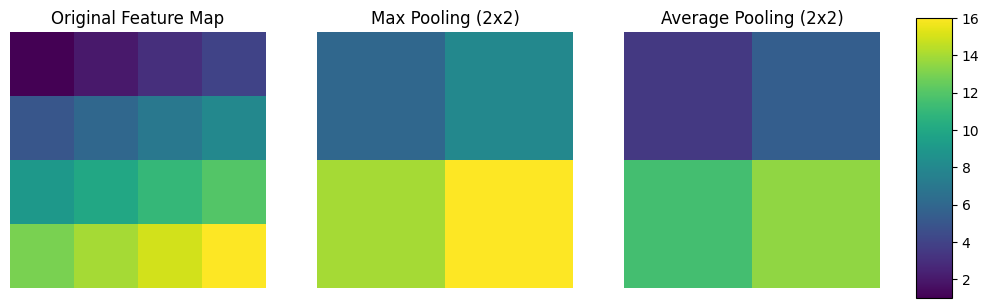

In [4]:
def pooling_operations():
    # Create a 4x4 feature map
    feature_map = torch.tensor([
        [1.0, 2.0, 3.0, 4.0],
        [5.0, 6.0, 7.0, 8.0],
        [9.0, 10.0, 11.0, 12.0],
        [13.0, 14.0, 15.0, 16.0]
    ]).unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
    
    # Define pooling operations
    max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
    avg_pool = nn.AvgPool2d(kernel_size=2, stride=2)
    
    # Apply pooling
    max_pooled = max_pool(feature_map)
    avg_pooled = avg_pool(feature_map)
    
    # Convert tensors to numpy arrays for visualization
    original = feature_map[0, 0].numpy()
    max_img = max_pooled[0, 0].numpy()
    avg_img = avg_pooled[0, 0].numpy()
    
    # Compute a common color scale (vmin and vmax) across all images
    all_data = np.concatenate([original.flatten(), max_img.flatten(), avg_img.flatten()])
    vmin = all_data.min()
    vmax = all_data.max()
    
    # Create subplots with a shared color range
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    im0 = axes[0].imshow(original, cmap='viridis', vmin=vmin, vmax=vmax)
    axes[0].set_title('Original Feature Map')
    axes[0].axis('off')
    
    im1 = axes[1].imshow(max_img, cmap='viridis', vmin=vmin, vmax=vmax)
    axes[1].set_title('Max Pooling (2x2)')
    axes[1].axis('off')
    
    im2 = axes[2].imshow(avg_img, cmap='viridis', vmin=vmin, vmax=vmax)
    axes[2].set_title('Average Pooling (2x2)')
    axes[2].axis('off')
    
    # Adjust layout to create space for a dedicated colorbar axis
    plt.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.88, 0.15, 0.03, 0.7])
    fig.colorbar(im0, cax=cbar_ax)
    
    plt.show()

print("\nDemonstrating pooling operations with a shared legend...")
pooling_operations()

## Fully Connected Layers

After several convolutional and pooling layers, we typically flatten the output and connect it to one or more fully connected layers for final classification.

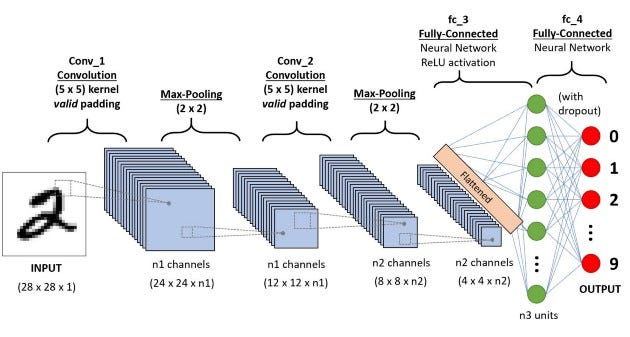

## Example CNN Architecture

Let's examine a simple CNN for MNIST digit classification:
Input: $28×28×1$ (grayscale images)

1. **Conv layer**: $5×5$ filters, $6$ filters, same padding → $28×28×6$

2. **Max pooling**: $2×2$, stride $2$ → $14×14×6$

3. **Conv layer**: $5×5$ filters, $16$ filters → $10×10×16$
   
4. **Max pooling**: $2×2$, stride $2$ → $5×5×16$

5. **Flatten**: $5×5×16 = 400$ units

6. **Fully connected**: $400 → 120$ units

7. **Fully connected**: $120 → 84$ units

8. **Output layer**: $84 → 10$ units (one per digit)

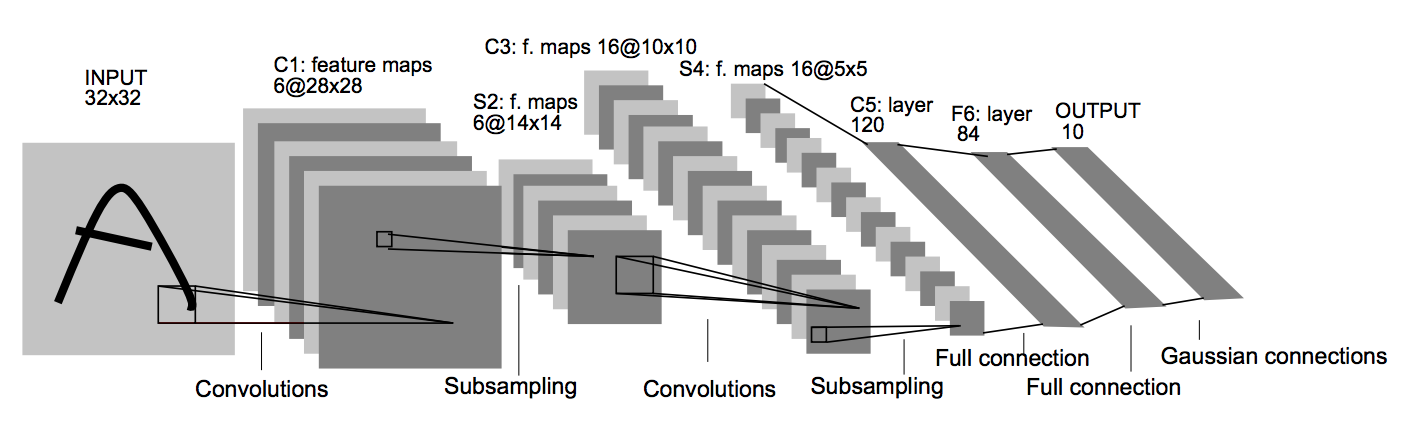

## Code - Part 4: Complete CNN for MNIST
The `SimpleCNN` class implements a complete CNN architecture similar to the one Andrew Ng describes in the course:

- **First convolutional layer**: $5×5$ filters, $6$ feature maps, with padding

- **Max pooling** with $2×2$ filters and stride $2$
  
- **Second convolutional layer**: $5×5$ filters, $16$ feature maps

- Another **max pooling** layer

- Three **fully connected layers** ($120$, $84$, and $10$ neurons)

The `train_mnist_cnn`() function:

- Loads and preprocesses the `MNIST` dataset

- Trains the `CNN` using stochastic gradient descent

- Tracks and visualizes the training progress (`loss` and `accuracy`)

This section ties together all the previous concepts into a complete, practical example of a `CNN` that can classify handwritten digits with high accuracy.

Training a CNN on MNIST...
Epoch [1/5], Step [100/938], Loss: 0.6681
Epoch [1/5], Step [200/938], Loss: 0.2770
Epoch [1/5], Step [300/938], Loss: 0.1562
Epoch [1/5], Step [400/938], Loss: 0.1101
Epoch [1/5], Step [500/938], Loss: 0.3664
Epoch [1/5], Step [600/938], Loss: 0.0937
Epoch [1/5], Step [700/938], Loss: 0.0112
Epoch [1/5], Step [800/938], Loss: 0.1364
Epoch [1/5], Step [900/938], Loss: 0.1136
Epoch [1/5], Train Loss: 0.3198, Train Acc: 89.55%, Test Acc: 97.69%
Epoch [2/5], Step [100/938], Loss: 0.0696
Epoch [2/5], Step [200/938], Loss: 0.0573
Epoch [2/5], Step [300/938], Loss: 0.0447
Epoch [2/5], Step [400/938], Loss: 0.0939
Epoch [2/5], Step [500/938], Loss: 0.1088
Epoch [2/5], Step [600/938], Loss: 0.1172
Epoch [2/5], Step [700/938], Loss: 0.0384
Epoch [2/5], Step [800/938], Loss: 0.0504
Epoch [2/5], Step [900/938], Loss: 0.0035
Epoch [2/5], Train Loss: 0.0635, Train Acc: 98.00%, Test Acc: 98.62%
Epoch [3/5], Step [100/938], Loss: 0.0400
Epoch [3/5], Step [200/938], Loss: 0.

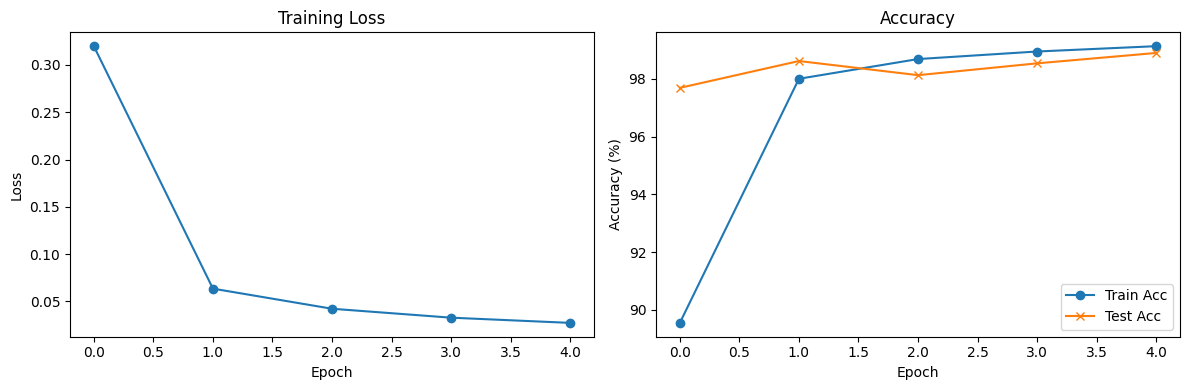

In [5]:
# Define the CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # First convolutional layer: Input 1x28x28, Output 6x28x28 (with padding)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Second convolutional layer: Input 6x14x14, Output 16x10x10
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        # First convolutional block
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        # Second convolutional block
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        # Flatten for fully connected layers
        x = x.view(-1, 16 * 5 * 5)
        
        # Fully connected layers
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.relu4(x)
        x = self.fc3(x)
        
        return x

def train_mnist_cnn(num_epochs=3):
    # Define data transformations
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    # Load MNIST dataset
    train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)
    
    # Initialize model, loss function, and optimizer
    model = SimpleCNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    
    train_losses = []
    train_accuracies = []
    test_accuracies = []
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, (images, labels) in enumerate(train_loader):
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            if (i+1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
        
        epoch_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(train_acc)
        
        # Evaluate on test dataset
        model.eval()
        with torch.no_grad():
            correct_test = 0
            total_test = 0
            for images, labels in test_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
            test_acc = 100 * correct_test / total_test
            test_accuracies.append(test_acc)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%')
    
    # Plot training progress
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, marker='o')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, marker='o', label='Train Acc')
    plt.plot(test_accuracies, marker='x', label='Test Acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Save the model
    torch.save(model.state_dict(), 'mnist_cnn.pth')
    return model, test_dataset

print("Training a CNN on MNIST...")
model, test_dataset = train_mnist_cnn(num_epochs=5)

## Code - Parts 5 & 6: Visualizing What's Happening Inside the CNN
These sections provide crucial insights into what the `CNN` is actually learning:

- `visualize_filters()` shows the learned filters in the first convolutional layer

- `visualize_feature_maps()` shows how a digit image is transformed as it passes through the network

These visualizations help you understand that:

- Early convolutional layers learn to detect simple features like **edges** and **curves**
  
- Each filter activates differently based on the input image's patterns
  
- Pooling layers progressively reduce spatial dimensions while preserving important features


Visualizing learned filters...


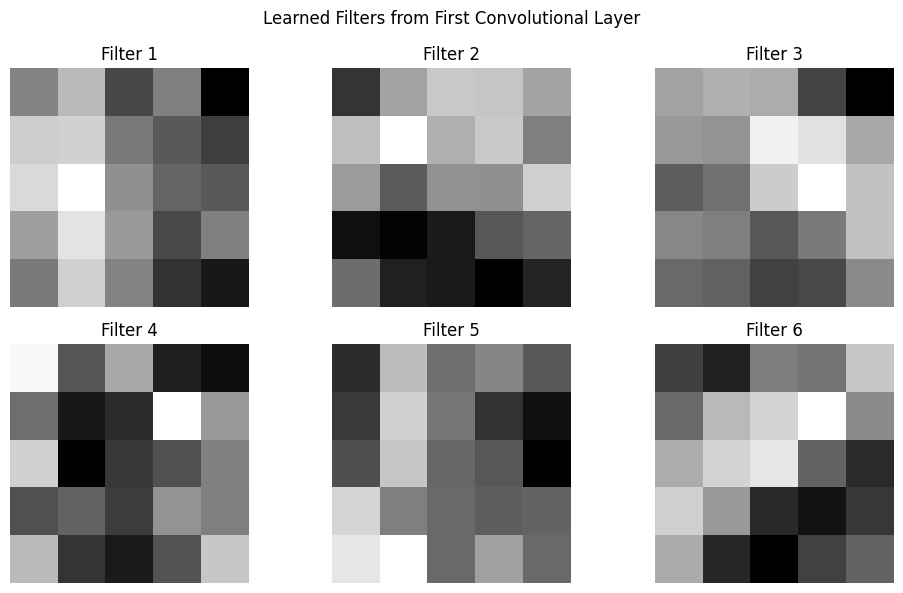


Visualizing filter applications on example images...


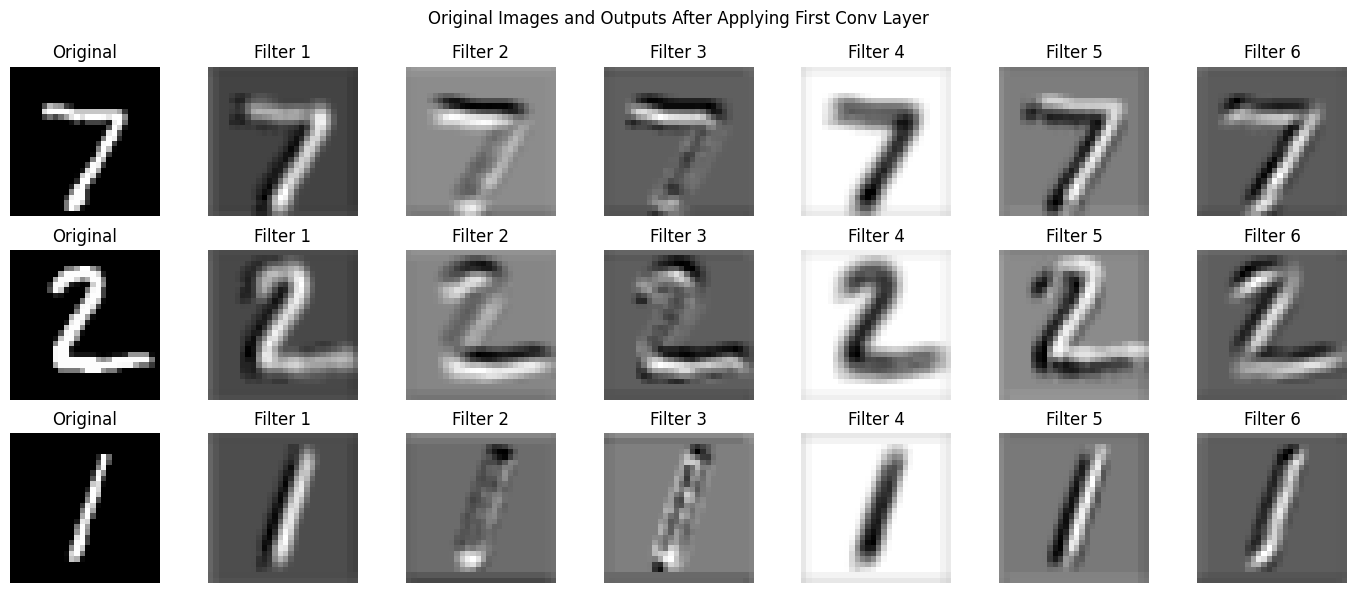


Visualizing feature maps for a sample digit...


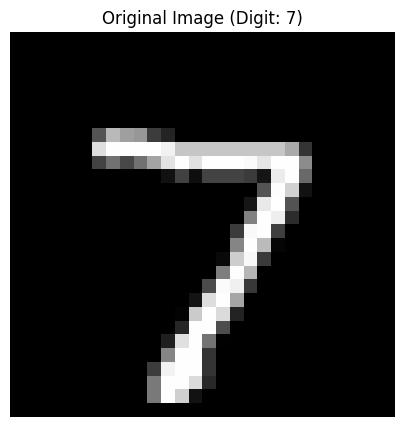

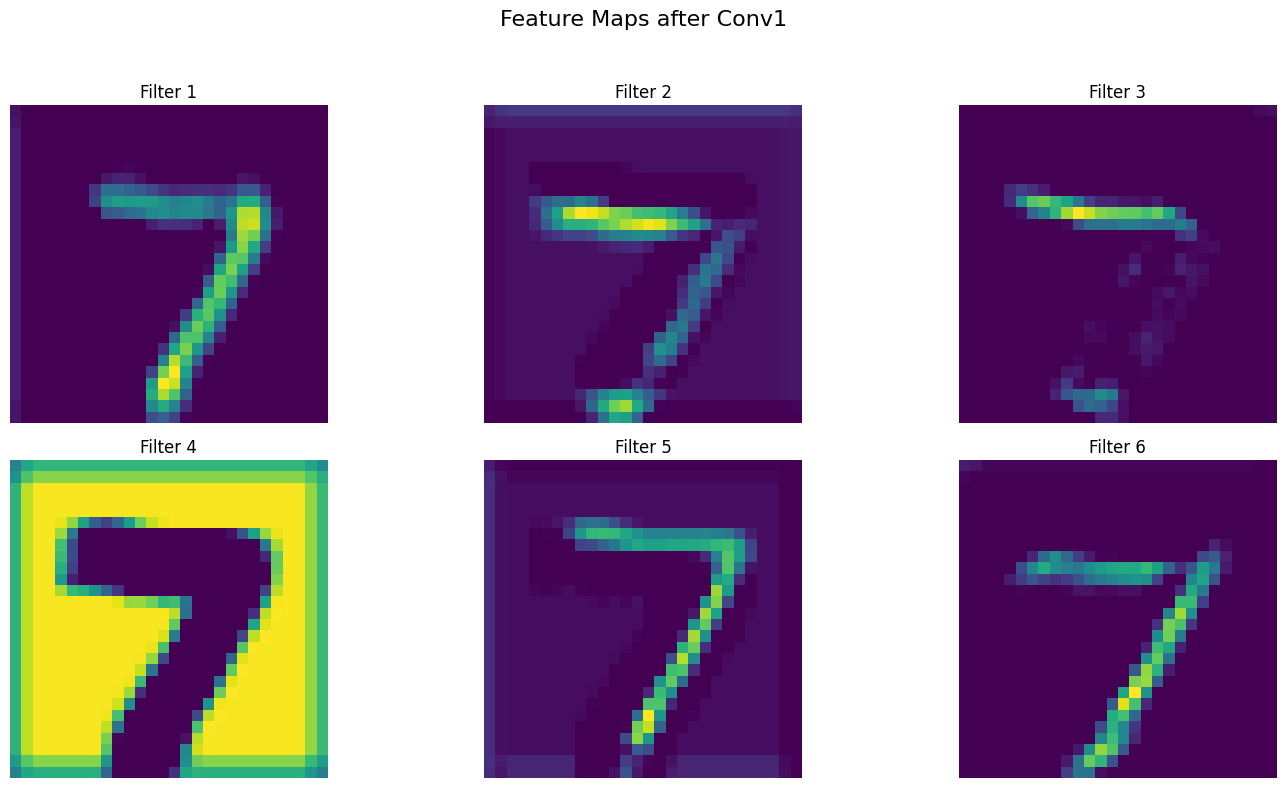

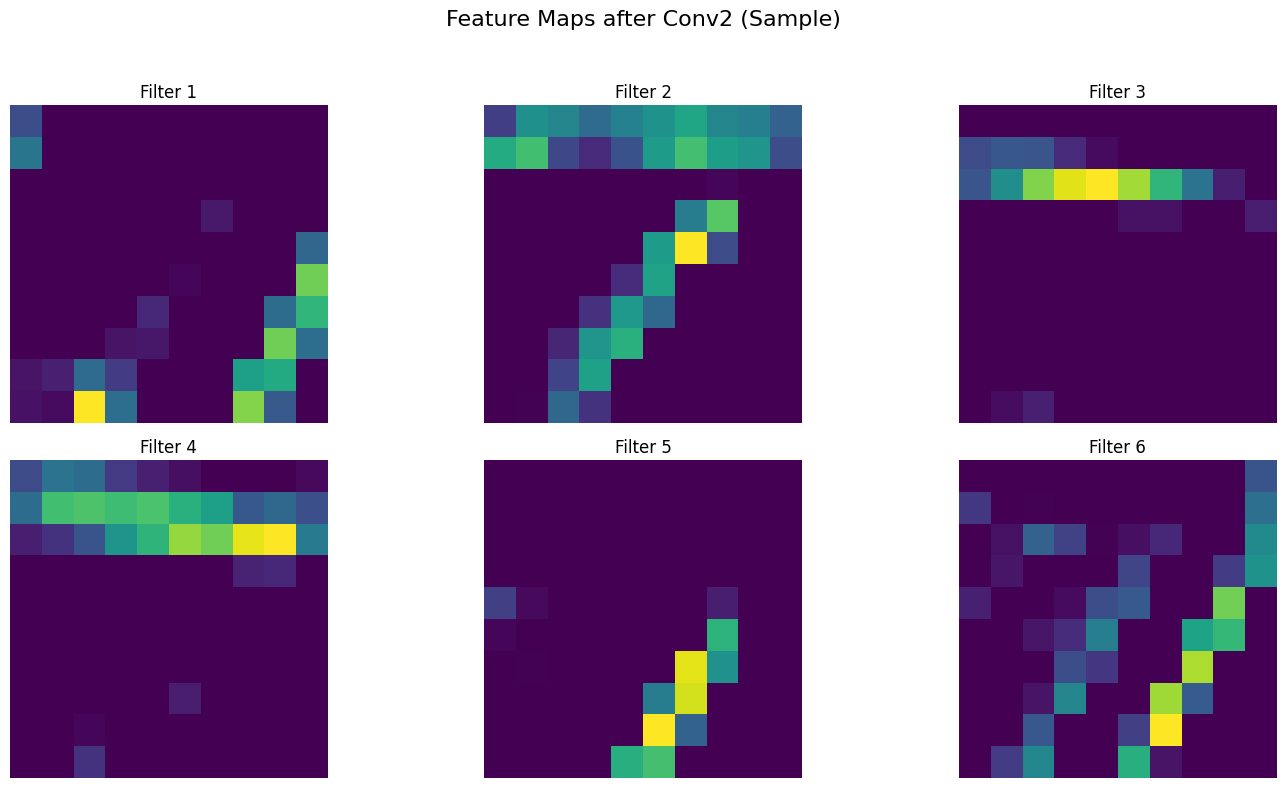

In [6]:
# Part 5: Visualizing learned filters
def visualize_filters(model):
    """
    Display the learned filters from the first convolutional layer.
    """
    weights = model.conv1.weight.data.numpy()  # Shape: (6, 1, 5, 5)
    
    fig, axes = plt.subplots(2, 3, figsize=(10, 6))
    for i in range(6):
        row, col = divmod(i, 3)
        axes[row, col].imshow(weights[i, 0], cmap='gray')
        axes[row, col].set_title(f'Filter {i+1}')
        axes[row, col].axis('off')
    
    plt.suptitle('Learned Filters from First Convolutional Layer')
    plt.tight_layout()
    plt.show()

def visualize_filter_application(model, dataset, num_examples=3):
    """
    For a few example images from the MNIST test set:
      - Show the original image.
      - Show the outputs of each filter from the first convolutional layer.
    """
    model.eval()
    num_filters = model.conv1.out_channels
    fig, axes = plt.subplots(num_examples, 1 + num_filters, figsize=(2 * (1 + num_filters), 2 * num_examples))
    
    for idx in range(num_examples):
        image, label = dataset[idx]
        # Original image: shape (1, 28, 28) -> squeeze to (28, 28)
        orig_img = image.squeeze(0).numpy()
        
        # If only one example, axes might be 1D
        if num_examples == 1:
            row_axes = axes
        else:
            row_axes = axes[idx]
        
        row_axes[0].imshow(orig_img, cmap='gray')
        row_axes[0].set_title('Original')
        row_axes[0].axis('off')
        
        # Add a batch dimension and pass through the first conv layer
        image_batch = image.unsqueeze(0)  # Shape: [1, 1, 28, 28]
        conv_output = model.conv1(image_batch)  # Output shape: [1, num_filters, 28, 28]
        conv_output = conv_output.detach().numpy()[0]  # Remove batch dim
        
        # Display each filter's output
        for f in range(num_filters):
            row_axes[f + 1].imshow(conv_output[f], cmap='gray')
            row_axes[f + 1].set_title(f'Filter {f+1}')
            row_axes[f + 1].axis('off')
    
    plt.suptitle('Original Images and Outputs After Applying First Conv Layer')
    plt.tight_layout()
    plt.show()

# Part 6: Visualizing feature maps
def visualize_feature_maps(model):
    # Load a sample image
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    # Load test dataset and get a sample image
    test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    image, label = test_dataset[0]  # Get the first test image
    image = image.unsqueeze(0)  # Add batch dimension
    
    # Set the model to evaluation mode
    model.eval()
    
    # Get feature maps from first convolutional layer
    with torch.no_grad():
        # Forward pass through first conv layer
        conv1_output = model.relu1(model.conv1(image))
        
        # Forward pass through first pooling layer
        pool1_output = model.pool1(conv1_output)
        
        # Forward pass through second conv layer
        conv2_output = model.relu2(model.conv2(pool1_output))
    
    # Visualize the original image
    plt.figure(figsize=(5, 5))
    plt.imshow(image[0, 0].numpy(), cmap='gray')
    plt.title(f'Original Image (Digit: {label})')
    plt.axis('off')
    plt.show()
    
    # Visualize feature maps after first convolution
    plt.figure(figsize=(15, 8))
    plt.suptitle('Feature Maps after Conv1', fontsize=16)
    for i in range(6):
        plt.subplot(2, 3, i+1)
        plt.imshow(conv1_output[0, i].numpy(), cmap='viridis')
        plt.title(f'Filter {i+1}')
        plt.axis('off')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
    # Visualize feature maps after second convolution (just a subset)
    plt.figure(figsize=(15, 8))
    plt.suptitle('Feature Maps after Conv2 (Sample)', fontsize=16)
    for i in range(6):
        plt.subplot(2, 3, i+1)
        plt.imshow(conv2_output[0, i].numpy(), cmap='viridis')
        plt.title(f'Filter {i+1}')
        plt.axis('off')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

print("\nVisualizing learned filters...")
visualize_filters(model)

print("\nVisualizing filter applications on example images...")
visualize_filter_application(model, test_dataset, num_examples=3)

print("\nVisualizing feature maps for a sample digit...")
visualize_feature_maps(model)

## Why Convolutions?

Convolutions offer two main advantages:

- **Parameter sharing**: A feature detector useful in one part of the image is likely useful in another part

- **Sparsity of connections**: Each output value depends only on a small number of inputs

These properties dramatically **reduce the number of parameters compared to fully connected networks**, making CNNs more efficient and less prone to overfitting.

## Summary

In Week 1, we've covered the fundamental building blocks of CNNs:

- The convolution operation and its parameters (`filter size`, `stride`, `padding`)

- How convolutions work with multi-channel inputs

- `Pooling layers` and their purpose

- The overall architecture of CNNs

These concepts form the foundation for more advanced CNN architectures that we'll explore in subsequent weeks. Understanding these basic operations is crucial for designing and implementing effective computer vision systems.